# Image generation


This notebook contains class visualization (or input image optimize) on PyTorch using MNIST and Fashion MNIST datasets.

In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
import torchvision.transforms as transforms
mnist_trainset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_testset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
print(len(mnist_trainset))
print(len(mnist_testset))

0it [00:00, ?it/s]

9920512it [00:01, 8101201.67it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135316.91it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2211438.84it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 51406.88it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
60000
10000


In [0]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_trainset, 
                                           batch_size=16, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_testset, 
                                          batch_size=16, 
                                          shuffle=False)

In [0]:
import torch
import numpy as np
from torch.nn import Linear, Sigmoid
import torch.nn.functional as F

def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss
    return train_step

def show_torch_image(torch_tensor):
    plt.imshow(torch_tensor.detach().numpy().reshape(28, 28), cmap='gray')
    plt.show()

# optimize image input
def generate_image(epochs, model, class_y, optimizer, loss_fn):

  X = torch.zeros((1, 1, 28, 28), requires_grad=True) # or we can X = noise()
  y = torch.empty(1,dtype = torch.long) 
  y[0] = class_y

  if optimizer == 'sgd': 
    optimizer = optim.SGD([X], lr = 0.01)
  else:
    return X

  for i in range(epochs):

    optimizer.zero_grad()
    pred = model(X) # forward pass for prediction
    loss = loss_fn(pred, y) # calc loss 
    loss.backward() # backward pass the loss from out to the input
    optimizer.step() # update weights(out input image)
    if i % 1000 == 0:
      print(loss)

  return X


def eval_acc(model, test_loader):
  model.eval()
  correct = 0
  total = 0
  for images, labels in test_loader:
    #images = images.reshape(-1, 28*28)
    images = images
    labels = labels
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  return correct / total

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        
        x = F.relu(F.max_pool2d(self.dropout(self.conv2(x)), 2))
        
        x = x.view(-1, 320)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        x = self.fc2(x)
        
        return x

Обучаем модель

In [273]:
from torch import optim, nn

model_mnist = CNNClassifier()

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model_mnist.parameters(), lr=0.01)

train_step = make_train_step(model_mnist, loss_fn, optimizer)
n_epochs = 4
loss = []
for epoch in range(n_epochs):
    for images, labels in train_loader:
        #images = images.reshape(-1, 28*28)
        batch_loss = train_step(images, labels)
        loss.append(batch_loss)
    print(epoch)
  


0
1
2
3


График потерь

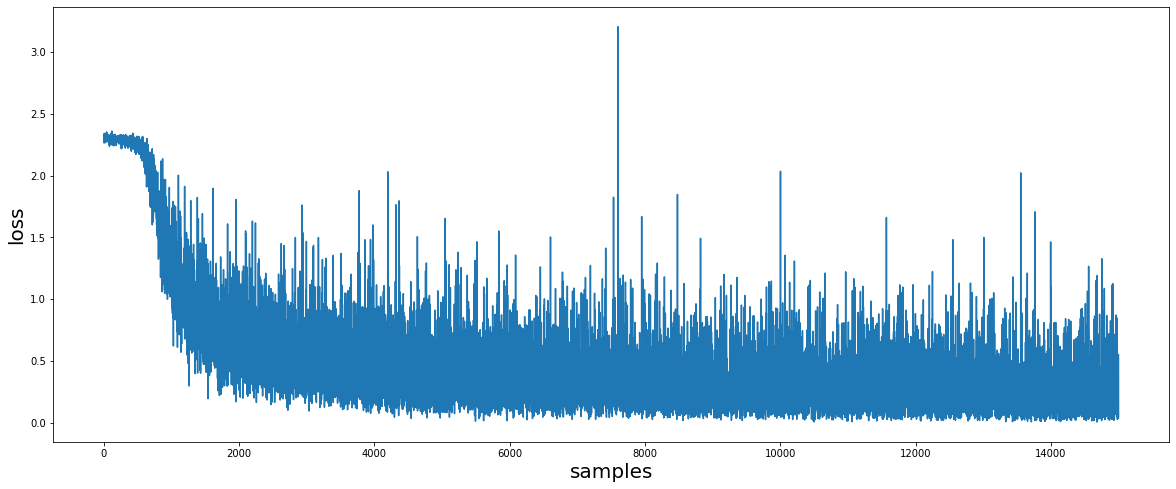

In [276]:
plt.figure(figsize=(20, 8))
plt.plot(loss)
plt.xlabel('samples', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show();

Оценка сети

In [275]:
print(eval_acc(model_mnist, test_loader))

0.9739


Let’s try to generate handwritten numeral images that are ideal for an already trained model.

 X - any input image (noise) - this will be our "weights" 
 
 y - the image class that we want to generate

The main idea is: pred = model.forward (x), loss = L (pred, y). Then we change each pixel of the image according to the formula: x_i = x_i - lr * dL/d(x_i)

We need the partial derivatives of the loss function with respect to the input pixels (their values).

Попробуем сгенерировать изображения рукописных цифр, которые идеально подходят для уже обученной модели. 

X - любое входное изображение(шум) - это и будут наши "веса"

y - класс изображения, который мы хотим сгенерировать

Идея такова: pred = model.forward(x), loss = L(pred, y).
Потом мы изменяем каждый пиксель изображения по формуле: 
x_i = x_i - lr * dL/d(x_i). Т.е. нам нужны частные производные от функции потерь по входным пикселям(их значениям).



class = 0
tensor(8.6906, grad_fn=<NllLossBackward>)
tensor(0.0256, grad_fn=<NllLossBackward>)
tensor(0.0119, grad_fn=<NllLossBackward>)
tensor(0.0077, grad_fn=<NllLossBackward>)
tensor(0.0056, grad_fn=<NllLossBackward>)
tensor(0.0044, grad_fn=<NllLossBackward>)
tensor(0.0036, grad_fn=<NllLossBackward>)
tensor(0.0031, grad_fn=<NllLossBackward>)
tensor(0.0027, grad_fn=<NllLossBackward>)
tensor(0.0024, grad_fn=<NllLossBackward>)


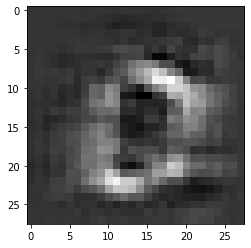

class = 1
tensor(9.6386, grad_fn=<NllLossBackward>)
tensor(0.6120, grad_fn=<NllLossBackward>)
tensor(0.0748, grad_fn=<NllLossBackward>)
tensor(0.0364, grad_fn=<NllLossBackward>)
tensor(0.0241, grad_fn=<NllLossBackward>)
tensor(0.0180, grad_fn=<NllLossBackward>)
tensor(0.0144, grad_fn=<NllLossBackward>)
tensor(0.0120, grad_fn=<NllLossBackward>)
tensor(0.0103, grad_fn=<NllLossBackward>)
tensor(0.0090, grad_fn=<NllLossBackward>)


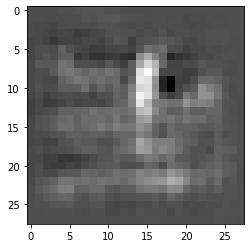

class = 2
tensor(8.1511, grad_fn=<NllLossBackward>)
tensor(0.0827, grad_fn=<NllLossBackward>)
tensor(0.0374, grad_fn=<NllLossBackward>)
tensor(0.0242, grad_fn=<NllLossBackward>)
tensor(0.0180, grad_fn=<NllLossBackward>)
tensor(0.0143, grad_fn=<NllLossBackward>)
tensor(0.0119, grad_fn=<NllLossBackward>)
tensor(0.0102, grad_fn=<NllLossBackward>)
tensor(0.0089, grad_fn=<NllLossBackward>)
tensor(0.0079, grad_fn=<NllLossBackward>)


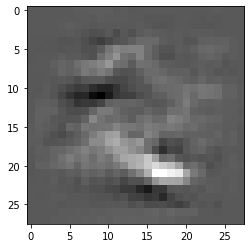

class = 3
tensor(10.2509, grad_fn=<NllLossBackward>)
tensor(0.0959, grad_fn=<NllLossBackward>)
tensor(0.0501, grad_fn=<NllLossBackward>)
tensor(0.0336, grad_fn=<NllLossBackward>)
tensor(0.0252, grad_fn=<NllLossBackward>)
tensor(0.0199, grad_fn=<NllLossBackward>)
tensor(0.0166, grad_fn=<NllLossBackward>)
tensor(0.0143, grad_fn=<NllLossBackward>)
tensor(0.0125, grad_fn=<NllLossBackward>)
tensor(0.0111, grad_fn=<NllLossBackward>)


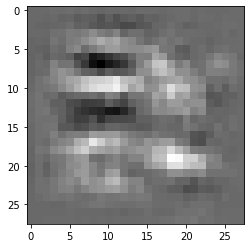

class = 4
tensor(10.1906, grad_fn=<NllLossBackward>)
tensor(0.0710, grad_fn=<NllLossBackward>)
tensor(0.0295, grad_fn=<NllLossBackward>)
tensor(0.0184, grad_fn=<NllLossBackward>)
tensor(0.0137, grad_fn=<NllLossBackward>)
tensor(0.0110, grad_fn=<NllLossBackward>)
tensor(0.0092, grad_fn=<NllLossBackward>)
tensor(0.0079, grad_fn=<NllLossBackward>)
tensor(0.0069, grad_fn=<NllLossBackward>)
tensor(0.0062, grad_fn=<NllLossBackward>)


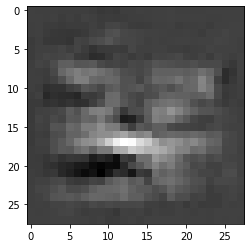

class = 5
tensor(8.6511, grad_fn=<NllLossBackward>)
tensor(0.9159, grad_fn=<NllLossBackward>)
tensor(0.3039, grad_fn=<NllLossBackward>)
tensor(0.1845, grad_fn=<NllLossBackward>)
tensor(0.1315, grad_fn=<NllLossBackward>)
tensor(0.1020, grad_fn=<NllLossBackward>)
tensor(0.0832, grad_fn=<NllLossBackward>)
tensor(0.0701, grad_fn=<NllLossBackward>)
tensor(0.0602, grad_fn=<NllLossBackward>)
tensor(0.0526, grad_fn=<NllLossBackward>)


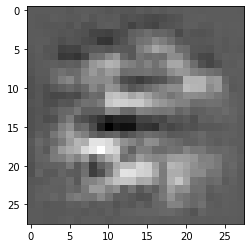

class = 6
tensor(8.6331, grad_fn=<NllLossBackward>)
tensor(0.0226, grad_fn=<NllLossBackward>)
tensor(0.0105, grad_fn=<NllLossBackward>)
tensor(0.0068, grad_fn=<NllLossBackward>)
tensor(0.0050, grad_fn=<NllLossBackward>)
tensor(0.0039, grad_fn=<NllLossBackward>)
tensor(0.0032, grad_fn=<NllLossBackward>)
tensor(0.0028, grad_fn=<NllLossBackward>)
tensor(0.0024, grad_fn=<NllLossBackward>)
tensor(0.0022, grad_fn=<NllLossBackward>)


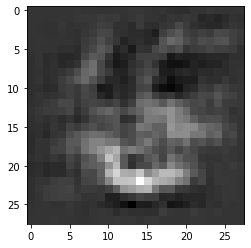

class = 7
tensor(8.8915, grad_fn=<NllLossBackward>)
tensor(0.0413, grad_fn=<NllLossBackward>)
tensor(0.0198, grad_fn=<NllLossBackward>)
tensor(0.0129, grad_fn=<NllLossBackward>)
tensor(0.0095, grad_fn=<NllLossBackward>)
tensor(0.0075, grad_fn=<NllLossBackward>)
tensor(0.0061, grad_fn=<NllLossBackward>)
tensor(0.0052, grad_fn=<NllLossBackward>)
tensor(0.0045, grad_fn=<NllLossBackward>)
tensor(0.0040, grad_fn=<NllLossBackward>)


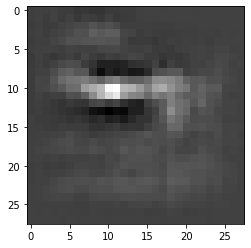

class = 8
tensor(6.0099, grad_fn=<NllLossBackward>)
tensor(0.0349, grad_fn=<NllLossBackward>)
tensor(0.0144, grad_fn=<NllLossBackward>)
tensor(0.0092, grad_fn=<NllLossBackward>)
tensor(0.0068, grad_fn=<NllLossBackward>)
tensor(0.0053, grad_fn=<NllLossBackward>)
tensor(0.0042, grad_fn=<NllLossBackward>)
tensor(0.0035, grad_fn=<NllLossBackward>)
tensor(0.0030, grad_fn=<NllLossBackward>)
tensor(0.0026, grad_fn=<NllLossBackward>)


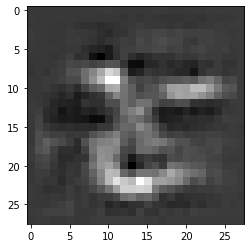

class = 9
tensor(0.0035, grad_fn=<NllLossBackward>)
tensor(0.0034, grad_fn=<NllLossBackward>)
tensor(0.0032, grad_fn=<NllLossBackward>)
tensor(0.0030, grad_fn=<NllLossBackward>)
tensor(0.0029, grad_fn=<NllLossBackward>)
tensor(0.0027, grad_fn=<NllLossBackward>)
tensor(0.0026, grad_fn=<NllLossBackward>)
tensor(0.0025, grad_fn=<NllLossBackward>)
tensor(0.0023, grad_fn=<NllLossBackward>)
tensor(0.0022, grad_fn=<NllLossBackward>)


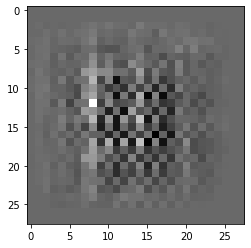

In [312]:
for i in range(10):
  print('class =', i)
  show_torch_image(generate_image(10000, model_mnist, i, 'sgd', loss_fn))

Повторим действия с fashion mnist

In [277]:
F_mnist_trainset = dsets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
F_mnist_testset = dsets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

  1%|          | 212992/26421880 [00:00<00:13, 1954457.48it/s]

26427392it [00:00, 84192529.00it/s]                             


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


32768it [00:00, 591980.61it/s]
 18%|█▊        | 811008/4422102 [00:00<00:00, 7739613.02it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


4423680it [00:00, 31450134.96it/s]                           
8192it [00:00, 197604.90it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw
Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [0]:
train_loader = torch.utils.data.DataLoader(dataset=F_mnist_trainset, 
                                           batch_size=16, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=F_mnist_testset, 
                                          batch_size=16, 
                                          shuffle=False)

In [283]:
model_F_mnist = CNNClassifier()

loss_F = torch.nn.CrossEntropyLoss()

optimizer_F = optim.SGD(model_F_mnist.parameters(), lr=0.01)

epochs = 4

train_step = make_train_step(model_F_mnist, loss_F, optimizer_F)

losses_F = []

for epoch in range(epochs):
    for images, labels in train_loader:
        #images = images.reshape(-1, 28*28)
        batch_loss = train_step(images, labels)
        losses_F.append(batch_loss)
    print(epoch)

0
1
2
3


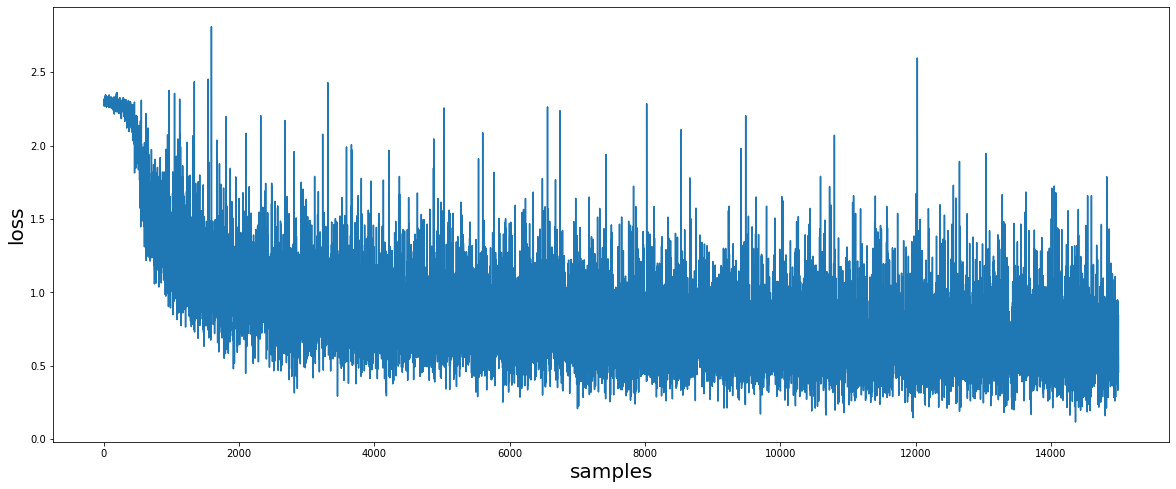

In [286]:
plt.figure(figsize=(20, 8))
plt.plot(losses_F)
plt.xlabel('samples', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show();

In [287]:
print(eval_acc(model_F_mnist, test_loader))

0.8079


class = T-Shirt
tensor(13.7413, grad_fn=<NllLossBackward>)
tensor(0.0396, grad_fn=<NllLossBackward>)
tensor(0.0217, grad_fn=<NllLossBackward>)
tensor(0.0152, grad_fn=<NllLossBackward>)
tensor(0.0119, grad_fn=<NllLossBackward>)
tensor(0.0098, grad_fn=<NllLossBackward>)
tensor(0.0084, grad_fn=<NllLossBackward>)
tensor(0.0073, grad_fn=<NllLossBackward>)
tensor(0.0065, grad_fn=<NllLossBackward>)
tensor(0.0058, grad_fn=<NllLossBackward>)


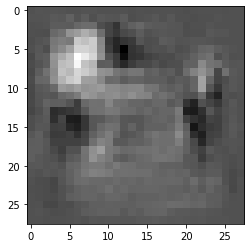

class = Trouser
tensor(12.8079, grad_fn=<NllLossBackward>)
tensor(0.0081, grad_fn=<NllLossBackward>)
tensor(0.0038, grad_fn=<NllLossBackward>)
tensor(0.0025, grad_fn=<NllLossBackward>)
tensor(0.0019, grad_fn=<NllLossBackward>)
tensor(0.0015, grad_fn=<NllLossBackward>)
tensor(0.0012, grad_fn=<NllLossBackward>)
tensor(0.0011, grad_fn=<NllLossBackward>)
tensor(0.0009, grad_fn=<NllLossBackward>)
tensor(0.0008, grad_fn=<NllLossBackward>)


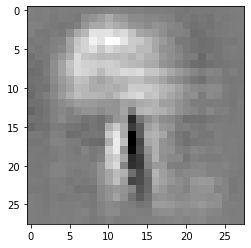

class = Pullover
tensor(15.7554, grad_fn=<NllLossBackward>)
tensor(0.2593, grad_fn=<NllLossBackward>)
tensor(0.1131, grad_fn=<NllLossBackward>)
tensor(0.0727, grad_fn=<NllLossBackward>)
tensor(0.0539, grad_fn=<NllLossBackward>)
tensor(0.0430, grad_fn=<NllLossBackward>)
tensor(0.0358, grad_fn=<NllLossBackward>)
tensor(0.0307, grad_fn=<NllLossBackward>)
tensor(0.0269, grad_fn=<NllLossBackward>)
tensor(0.0239, grad_fn=<NllLossBackward>)


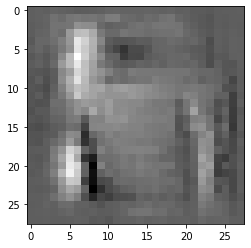

class = Dress
tensor(13.6258, grad_fn=<NllLossBackward>)
tensor(0.0419, grad_fn=<NllLossBackward>)
tensor(0.0211, grad_fn=<NllLossBackward>)
tensor(0.0139, grad_fn=<NllLossBackward>)
tensor(0.0101, grad_fn=<NllLossBackward>)
tensor(0.0077, grad_fn=<NllLossBackward>)
tensor(0.0063, grad_fn=<NllLossBackward>)
tensor(0.0053, grad_fn=<NllLossBackward>)
tensor(0.0046, grad_fn=<NllLossBackward>)
tensor(0.0041, grad_fn=<NllLossBackward>)


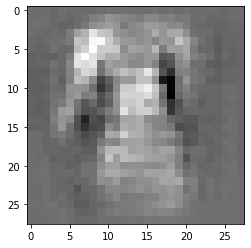

class = Coat
tensor(15.8068, grad_fn=<NllLossBackward>)
tensor(0.1322, grad_fn=<NllLossBackward>)
tensor(0.0585, grad_fn=<NllLossBackward>)
tensor(0.0377, grad_fn=<NllLossBackward>)
tensor(0.0279, grad_fn=<NllLossBackward>)
tensor(0.0222, grad_fn=<NllLossBackward>)
tensor(0.0184, grad_fn=<NllLossBackward>)
tensor(0.0157, grad_fn=<NllLossBackward>)
tensor(0.0137, grad_fn=<NllLossBackward>)
tensor(0.0122, grad_fn=<NllLossBackward>)


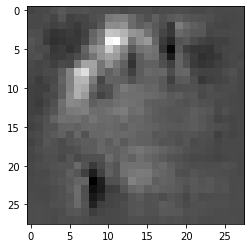

class = Sandal
tensor(6.2523, grad_fn=<NllLossBackward>)
tensor(0.0463, grad_fn=<NllLossBackward>)
tensor(0.0211, grad_fn=<NllLossBackward>)
tensor(0.0138, grad_fn=<NllLossBackward>)
tensor(0.0102, grad_fn=<NllLossBackward>)
tensor(0.0081, grad_fn=<NllLossBackward>)
tensor(0.0067, grad_fn=<NllLossBackward>)
tensor(0.0057, grad_fn=<NllLossBackward>)
tensor(0.0050, grad_fn=<NllLossBackward>)
tensor(0.0044, grad_fn=<NllLossBackward>)


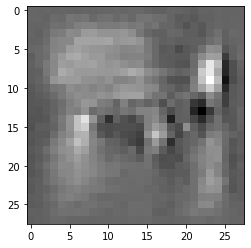

class = Shirt
tensor(15.4112, grad_fn=<NllLossBackward>)
tensor(0.1548, grad_fn=<NllLossBackward>)
tensor(0.0540, grad_fn=<NllLossBackward>)
tensor(0.0330, grad_fn=<NllLossBackward>)
tensor(0.0238, grad_fn=<NllLossBackward>)
tensor(0.0187, grad_fn=<NllLossBackward>)
tensor(0.0153, grad_fn=<NllLossBackward>)
tensor(0.0130, grad_fn=<NllLossBackward>)
tensor(0.0113, grad_fn=<NllLossBackward>)
tensor(0.0100, grad_fn=<NllLossBackward>)


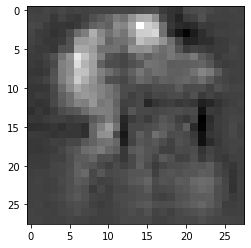

class = Sneaker
tensor(5.9677, grad_fn=<NllLossBackward>)
tensor(0.5038, grad_fn=<NllLossBackward>)
tensor(0.1705, grad_fn=<NllLossBackward>)
tensor(0.0861, grad_fn=<NllLossBackward>)
tensor(0.0588, grad_fn=<NllLossBackward>)
tensor(0.0450, grad_fn=<NllLossBackward>)
tensor(0.0366, grad_fn=<NllLossBackward>)
tensor(0.0309, grad_fn=<NllLossBackward>)
tensor(0.0269, grad_fn=<NllLossBackward>)
tensor(0.0238, grad_fn=<NllLossBackward>)


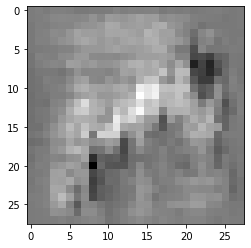

class = Bag
tensor(6.6266, grad_fn=<NllLossBackward>)
tensor(0.0055, grad_fn=<NllLossBackward>)
tensor(0.0031, grad_fn=<NllLossBackward>)
tensor(0.0022, grad_fn=<NllLossBackward>)
tensor(0.0017, grad_fn=<NllLossBackward>)
tensor(0.0014, grad_fn=<NllLossBackward>)
tensor(0.0012, grad_fn=<NllLossBackward>)
tensor(0.0011, grad_fn=<NllLossBackward>)
tensor(0.0009, grad_fn=<NllLossBackward>)
tensor(0.0008, grad_fn=<NllLossBackward>)


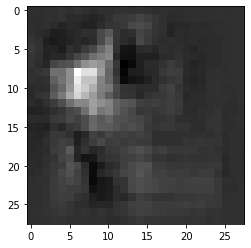

class = Ankle Boot
tensor(0.0058, grad_fn=<NllLossBackward>)
tensor(0.0042, grad_fn=<NllLossBackward>)
tensor(0.0031, grad_fn=<NllLossBackward>)
tensor(0.0025, grad_fn=<NllLossBackward>)
tensor(0.0020, grad_fn=<NllLossBackward>)
tensor(0.0017, grad_fn=<NllLossBackward>)
tensor(0.0015, grad_fn=<NllLossBackward>)
tensor(0.0013, grad_fn=<NllLossBackward>)
tensor(0.0011, grad_fn=<NllLossBackward>)
tensor(0.0010, grad_fn=<NllLossBackward>)


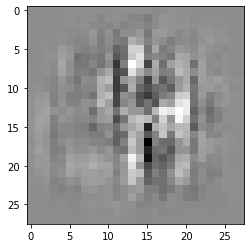

In [309]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};

for i in range(10):
  print('class =', labels_map[i])
  show_torch_image(generate_image(10000, model_F_mnist, i, 'sgd', loss_F))